In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import time
import logging

## Feature-scaling stack
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, OneHotEncoder, FunctionTransformer

## Dimesionality reduction
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif

## Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.combine import SMOTEENN

## Machine-learning stack
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, AdaBoostClassifier 
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

## Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_curve, roc_auc_score, auc, fbeta_score, f1_score

## Model saving
from joblib import dump, load

import warnings
warnings.filterwarnings('ignore')

# Control Variables

In [2]:
ENABLE = {
    'rf':     {'cross-val':    1,
               'compute-pauc': 1,
               'final-train':  1,
               'save-model':   1,
              },
    'xgb':    {'cross-val':    1,
               'compute-pauc': 1,
               'final-train':  1,
               'save-model':   1,
              },
    'lgb':    {'cross-val':    1,
               'compute-pauc': 1,
               'final-train':  1,
               'save-model':   1,
              },
    'cb':     {'cross-val':    0,
               'compute-pauc': 0,
               'final-train':  0,
               'save-model':   0,
              },
    'ada':    {'cross-val':    0,
               'compute-pauc': 0,
               'final-train':  0,
               'save-model':   0,
              },
    'svc':    {'cross-val':    0,
               'compute-pauc': 0,
               'final-train':  0,
               'save-model':   0,
              },
    'soft-v': {'cross-val':    0,
               'compute-pauc': 0,
               'final-train':  0,
               'save-model':   0,
              },
    'lr-v':   {'cross-val':    0,
               'compute-pauc': 0,
               'final-train':  0,
               'save-model':   0,
              },
}

# Evaluation Functions

In [3]:
def partial_auc_score(y_actual, y_scores, tpr_threshold=0.80):
    max_fpr = 1 - tpr_threshold

    # create numpy arrays
    y_actual = np.asarray(y_actual)
    y_scores = np.asarray(y_scores)

    # ROC curve
    fpr, tpr, _ = roc_curve(y_actual, y_scores)

    # Find the index where fpr exceeds max_fpr
    stop_index = np.searchsorted(fpr, max_fpr, side='right')

    if stop_index < len(fpr):
        # Interpolate to find the TPR at max_fpr
        fpr_interp_points = [fpr[stop_index - 1], fpr[stop_index]]
        tpr_interp_points = [tpr[stop_index - 1], tpr[stop_index]]
        tpr = np.append(tpr[:stop_index], np.interp(max_fpr, fpr_interp_points, tpr_interp_points))
        fpr = np.append(fpr[:stop_index], max_fpr)
    else:
        tpr = np.append(tpr, 1.0)
        fpr = np.append(fpr, max_fpr)

    # Calculate partial AUC
    partial_auc_value = auc(fpr, tpr)

    return partial_auc_value

def cross_val_partial_auc_score(X, y, model, n_splits):

     # Setup cross-validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    pauc_scores = []
    cont = 1
   
    for train_idx, val_idx in skf.split(X, y):

        print(f'Processing fold {cont} of {n_splits}... ', end='', flush=True)
        
        # Create the folds
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
                
        # Train the model
        model.fit(X_train_fold, y_train_fold)
    
        # Predict on the validation set
        preds = model.predict_proba(X_val_fold)[:,1]
   
        # Calculate partical AUC and store it
        pauc = partial_auc_score(y_val_fold, preds)
        pauc_scores.append(pauc)

        print(f'pAUC: {pauc}', flush=True)

        #predictions.append((val_idx, preds))
        
        cont = cont + 1
    
    # Return the average
    return np.mean(pauc_scores)

 #prediction_list = np.zeros((len(X)))  # Initialize full feature matrix
    #isic_id_list = [None] * len(X)

    #for val_idx, val_preds in predictions:
    #    prediction_list[val_idx] = val_preds
    #    isic_id_list[val_idx] = df.iloc[val_idx]['isic_id']

    #df_preds = pd.DataFrame({
    #    'isic_id': isic_id_list,
    #    'predictions': prediction_list
    #})

# Model Loading and Data Analysis

In [4]:
# Read the metadata-based feature set
ROOT_DATASET_DIR = "./"
file_name_data = os.path.join(ROOT_DATASET_DIR,"train-metadata-eda-fe.csv")
df_data = pd.read_csv(file_name_data)

# Read the image (pixel)-based feature set
file_name_img = os.path.join(ROOT_DATASET_DIR,"train-cnn-preds-rn152v2.csv")
df_img = pd.read_csv(file_name_img)

In [5]:
df_data.drop(columns=['isic_id'], inplace=True)
df_data['anatom_site_general'] = pd.Categorical(df_data['anatom_site_general'])
df_data['tbp_lv_location'] = pd.Categorical(df_data['tbp_lv_location'])
df_data['tbp_lv_location_simple'] = pd.Categorical(df_data['tbp_lv_location_simple'])
df_data['sex'] = pd.Categorical(df_data['sex'])
#df_data['age_approx'] = pd.Categorical(df_data['age_approx'])
#df_img.drop(columns=['target'], inplace=True)
df = df_data.copy() #pd.concat([df_data, df_img], axis=1)

# Feature Preparation

Some new features are from other notebooks at: https://www.kaggle.com/competitions/isic-2024-challenge/code

In [6]:
# Original feature names
features_to_be_logtr = ['clin_size_long_diam_mm',
                        'tbp_lv_areaMM2',
                        'tbp_lv_area_perim_ratio',
                        'tbp_lv_color_std_mean',
                        'tbp_lv_deltaLB',
                        'tbp_lv_deltaLBnorm',
                        'tbp_lv_minorAxisMM',
                        'tbp_lv_norm_border',
                        'tbp_lv_norm_color',
                        'tbp_lv_perimeterMM',
                        'tbp_lv_radial_color_std_max',
                        'tbp_lv_stdL',
                        'tbp_lv_stdLExt',
                        'tbp_lv_symm_2axis']
features_to_be_sqrtr = ['tbp_lv_eccentricity']

# Modified original feature names
log_features = ['log_' + col for col in features_to_be_logtr]
sqr_features = ['sqr_' + col for col in features_to_be_sqrtr]

# New feature names
new_features_to_be_logtr = ['hue_contrast',
                            'luminance_contrast',
                            'lesion_color_difference',
                            'border_complexity',
                            'perimeter_to_area_ratio',
                            'area_to_perimeter_ratio',
                            'lesion_visibility_score',
                            'symmetry_border_consistency',
                            'consistency_symmetry_border',
                            'consistency_color',
                            'size_age_interaction',
                            'lesion_severity_index',
                            'shape_complexity_index',
                            'std_dev_contrast',
                            'color_shape_composite_index',
                            'symmetry_perimeter_interaction',
                            'comprehensive_lesion_index',
                            'border_color_interaction',
                            'size_color_contrast_ratio',
                            'age_normalized_nevi_confidence',
                            'volume_approximation_3d',
                            'color_range',
                            'age_size_symmetry_index',
                            'index_age_size_symmetry']
new_features_to_be_sqrtr = ['lesion_shape_index',
                            'position_distance_3d']
new_features_to_be_sqrttr = ['color_consistency',
                             'hue_color_std_interaction',
                             'normalized_lesion_size',                            
                             'color_variance_ratio',
                             'color_asymmetry_index',
                             'shape_color_consistency']

# Modify the column names
log_new_features = ['log_' + col for col in new_features_to_be_logtr]
sqr_new_features = ['sqr_' + col for col in new_features_to_be_sqrtr]
sqrt_new_features = ['sqrt_' + col for col in new_features_to_be_sqrttr]

# Preparing Feature Dataset and Targets

In [7]:
# Train-Test split
# Drop non-used features for the baseline + target
X = df.drop(['target']
             + features_to_be_logtr + features_to_be_sqrtr                                         # drop original features with skeweness (no transformation)                          
             + new_features_to_be_logtr + new_features_to_be_sqrtr + new_features_to_be_sqrttr,    # drop new features with skeweness (no transformation)             
             axis=1)
y = df['target']

In [8]:
#cnn_feature = ['cnn_cancer_prob']
numerical_features = X.select_dtypes(include=['float64','int64']).columns.tolist()
#numerical_features.remove('cnn_cancer_prob')
categorical_features = X.select_dtypes(include=['category']).columns.tolist()
print(f"Numerical features: {numerical_features} - Length: {len(numerical_features)}")
print(f"Categorical features: {categorical_features} - Length: {len(categorical_features)}")

Numerical features: ['age_approx', 'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_nevi_confidence', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'log_clin_size_long_diam_mm', 'log_tbp_lv_areaMM2', 'log_tbp_lv_area_perim_ratio', 'log_tbp_lv_color_std_mean', 'log_tbp_lv_deltaLB', 'log_tbp_lv_deltaLBnorm', 'log_tbp_lv_minorAxisMM', 'log_tbp_lv_norm_border', 'log_tbp_lv_norm_color', 'log_tbp_lv_perimeterMM', 'log_tbp_lv_radial_color_std_max', 'log_tbp_lv_stdL', 'log_tbp_lv_stdLExt', 'log_tbp_lv_symm_2axis', 'sqr_tbp_lv_eccentricity', 'lesion_size_ratio', 'color_contrast_index', 'log_lesion_area', 'mean_hue_difference', 'lesion_orientation_3d', 'overall_color_difference', 'border_color_interaction_2', 'age_normalized_nevi_confidence_2', 'border_length_ratio', 'log_hue_contrast', 'log_luminance_contrast', 'log_le

# Dimensionality Reduction

In [11]:
# Use SelectKBest (f_classif) for numerical features
Kbest_numerical = SelectKBest(score_func=f_classif, k='all')
Kbest_numerical.fit(X[numerical_features], y)

# Extract feature scores and p-values
scores = Kbest_numerical.scores_
pvalues = Kbest_numerical.pvalues_

# Create a DataFrame to save feature names, scores, and p-values
feature_scores = pd.DataFrame({
    'Feature': numerical_features,
    'Score': scores,
    'P-Value': pvalues
})

# Sort features by 'Score'
best_feature_scores = feature_scores[feature_scores['P-Value'] < 0.05]
sorted_features = best_feature_scores.sort_values(by='Score', ascending=False)

#print(sorted_features.iloc['age_approx'])

# Display the sorted features
KBEST_NUM = sorted_features.shape[0]
print(f"Number of relevant numerical features: {KBEST_NUM}\n")
print(sorted_features.set_index('Feature'))

best_numerical_features = sorted_features.index.tolist()



Number of relevant numerical features: 67

                                      Score        P-Value
Feature                                                   
tbp_lv_H                         810.064722  5.299787e-178
mean_hue_difference              685.574310  5.521188e-151
tbp_lv_deltaB                    494.982298  1.371643e-109
tbp_lv_Hext                      429.257779   2.649970e-95
overall_color_difference         347.649336   1.487310e-77
...                                     ...            ...
lesion_size_ratio                 10.627077   1.114531e-03
log_symmetry_border_consistency    8.738379   3.115998e-03
tbp_lv_L                           6.699025   9.646915e-03
sqrt_hue_color_std_interaction     6.449304   1.109996e-02
sqrt_color_variance_ratio          3.877523   4.893741e-02

[67 rows x 2 columns]


In [17]:
sorted_features[sorted_features.Feature == 'age_approx']

,Feature,Score,P-Value
0,age_approx,24.774838,6.446013e-07


In [16]:
sorted_features

,Feature,Score,P-Value
8,tbp_lv_H,810.064722,5.299787e-178
38,mean_hue_difference,685.574310,5.521188e-151
13,tbp_lv_deltaB,494.982298,1.371643e-109
9,tbp_lv_Hext,429.257779,2.649970e-95
40,overall_color_difference,347.649336,1.487310e-77
...,...,...,...
35,lesion_size_ratio,10.627077,1.114531e-03
51,log_symmetry_border_consistency,8.738379,3.115998e-03
10,tbp_lv_L,6.699025,9.646915e-03
71,sqrt_hue_color_std_interaction,6.449304,1.109996e-02


In [ ]:
# Use SelectKBest (chi2) for categorical features

# Build a pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), categorical_features)
    ],
    remainder='drop'
)

pipeline = Pipeline(steps=[
    ('onehot', preprocessor),
    ('kbest', SelectKBest(score_func=chi2, k='all'))
])

cat_transformed = pipeline.fit_transform(X, y)
Kbest_categorical = pipeline.named_steps['kbest']

# Extract feature scores and p-values
scores = Kbest_categorical.scores_
pvalues = Kbest_categorical.pvalues_

# Extract feature names after one-hot encoding
one_hot_feature_names = pipeline.named_steps['onehot'].transformers_[0][1].get_feature_names_out(categorical_features)

# Create a DataFrame to hold feature names, scores, and p-values
feature_scores = pd.DataFrame({
    'Feature': one_hot_feature_names,
    'Score': scores,
    'P-Value': pvalues
})

# Sort features by their scores
best_feature_scores = feature_scores[feature_scores['P-Value'] < 0.05]
sorted_features = best_feature_scores.sort_values(by='Score', ascending=False)

# Display the sorted features
KBEST_CAT = sorted_features.shape[0]
print(f"Number of relevant categorical features: {KBEST_CAT}\n")
print(sorted_features.set_index('Feature'))

best_categorical_features = sorted_features.index.tolist()

best_features = best_numerical_features + best_categorical_features

# Preprocessing Pipeline 

In [18]:
# Pipeline
from sklearn.preprocessing import FunctionTransformer
   
pipe_num = Pipeline([
    ('scaler', RobustScaler()),
    #('kbest', SelectKBest(score_func=f_classif, k=67)),   
])

pipe_cat = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)),
    #('kbest', SelectKBest(score_func=chi2, k=8)),    
])

preprocessing = ColumnTransformer(transformers=[
    ('numerical', 'passthrough', numerical_features), # pipe_num, numerical_features),
    ('categorical', pipe_cat, categorical_features),
    #('cnn_prob', 'passthrough', cnn_feature),
])

# Balanced Random Forest

### Cross-validation

In [87]:
if ENABLE['rf']['cross-val'] == 1:
    
    # Setup cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Define the objective function
    def objective(trial):
        # Suggest values for the hyperparameters
        n_estimators = trial.suggest_int('n_estimators', 100, 400)
        max_features = trial.suggest_categorical('max_features', [None, 'sqrt'])
        criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
        max_depth = trial.suggest_int('max_depth', 5, 40) #10, #30)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10) #7)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20) #1, 20) #10) #5)   
        bootstrap=True
        class_weight=trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample'])
    
        pauc_scores = []
    
        for train_idx, val_idx in skf.split(X, y):
            
            # Create the folds
            X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
            y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
                        
            # Pipeline                           
            pipe_rf = ImbPipeline([
                ('preprocessing', preprocessing),
                ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
                ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),
                ('RF', BalancedRandomForestClassifier(random_state=42,
                                                      n_estimators=n_estimators,
                                                      max_features=max_features,
                                                      criterion=criterion,
                                                      max_depth=max_depth,
                                                      min_samples_split=min_samples_split,
                                                      min_samples_leaf=min_samples_leaf,
                                                      bootstrap=bootstrap,
                                                      class_weight=class_weight
                                                     )
                )
            ])
    
            # Train the model
            pipe_rf.fit(X_train_fold, y_train_fold)
        
            # Predict on the validation set
            preds = pipe_rf.predict_proba(X_val_fold)[:,1]
        
            # Calculate partical AUC and store it
            pauc = partial_auc_score(y_val_fold, preds)
            pauc_scores.append(pauc)
        
        # Return the average
        return np.mean(pauc_scores)
    
    # Create a study object with 'maximize' direction
    study = optuna.create_study(direction='maximize')
    
    # Start the optimization
    study.optimize(objective, n_trials=500, n_jobs=-1)
    
    # Get the best trial
    best_trial = study.best_trial
    
    print(f'Best trial number: {best_trial.number}')
    print(f'Best value (partial auc - 0.8): {best_trial.value}')
    print(f'Best hyperparameters: {best_trial.params}')
    
#Best trial number: 18
#Best value (partial auc - 0.8): 0.19099394435542486
#Best hyperparameters: {'n_estimators': 138, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 8}

#Best trial number: 78
#Best value (partial auc - 0.8): 0.16031750840546238
#Best hyperparameters: {'n_estimators': 335, 'max_depth': 28, 'min_samples_split': 6, 'min_samples_leaf': 10}

#Best trial number: 89
#Best value (partial auc - 0.8): 0.16040118245669321
#Best hyperparameters: {'n_estimators': 327, 'max_depth': 29, 'min_samples_split': 5, 'min_samples_leaf': 11}

#Best trial number: 140
#Best value (partial auc - 0.8): 0.16352981826819957
#Best hyperparameters: {'n_estimators': 391, 'max_features': None, 'criterion': 'entropy', 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 5}

#Trial 88 finished with value: 0.16360070800646104 and parameters: {'n_estimators': 249, 'max_features': 'sqrt', 'criterion': 'entropy', 'max_depth': 22, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 88 with value: 0.16360070800646104.

# USING 75 features (kbest)
#Best trial number: 401
#Best value (partial auc - 0.8): 0.15871657362495362
#Best hyperparameters: {'n_estimators': 186, 'max_features': 'sqrt', 'criterion': 'entropy', 'max_depth': 34, 'min_samples_split': 8, 'min_samples_leaf': 6, 'class_weight': 'balanced_subsample'}

# Using all features
#Best trial number: 455
#Best value (partial auc - 0.8): 0.15884962548132875
#Best hyperparameters: {'n_estimators': 162, 'max_features': 'sqrt', 'criterion': 'entropy', 'max_depth': 26, 'min_samples_split': 5, 'min_samples_leaf': 1, 'class_weight': 'balanced_subsample'}

[I 2024-08-28 19:08:00,283] A new study created in memory with name: no-name-61dfb1e8-72fc-4e4e-8f35-251544e32f36
[I 2024-08-28 19:09:19,211] Trial 10 finished with value: 0.15195595172194867 and parameters: {'n_estimators': 111, 'max_features': 'sqrt', 'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 19, 'class_weight': 'balanced_subsample'}. Best is trial 10 with value: 0.15195595172194867.
[I 2024-08-28 19:09:46,716] Trial 4 finished with value: 0.15605043482107278 and parameters: {'n_estimators': 117, 'max_features': 'sqrt', 'criterion': 'gini', 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 2, 'class_weight': 'balanced_subsample'}. Best is trial 4 with value: 0.15605043482107278.
[I 2024-08-28 19:10:01,248] Trial 0 finished with value: 0.1511644000809357 and parameters: {'n_estimators': 121, 'max_features': 'sqrt', 'criterion': 'gini', 'max_depth': 40, 'min_samples_split': 5, 'min_samples_leaf': 3, 'class_weight': 'balanced'}. Best is 

Best trial number: 455
Best value (partial auc - 0.8): 0.15884962548132875
Best hyperparameters: {'n_estimators': 162, 'max_features': 'sqrt', 'criterion': 'entropy', 'max_depth': 26, 'min_samples_split': 5, 'min_samples_leaf': 1, 'class_weight': 'balanced_subsample'}


### Cross-validation Partial AUC Score

In [17]:
param_rf = {
    'random_state': 42,
    'n_estimators': 162, #186, #391, #138,
    'max_features': 'sqrt', #None,
    'criterion': 'entropy',
    'max_depth': 26, #34, #17, #12,
    'min_samples_split': 5, #8, #4, #5,
    'min_samples_leaf': 1, #6, #5, #8,
    'bootstrap': True,
    'class_weight': 'balanced_subsample',
    'n_jobs': -1
}

model_rf_cv = ImbPipeline([    
    ('preprocessing', preprocessing),
    ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
    ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),
    ('RF',  BalancedRandomForestClassifier(**param_rf))
])

if ENABLE['rf']['compute-pauc'] == 1:
    pauc_rf_cv = cross_val_partial_auc_score(X, y, model_rf_cv, n_splits=5)    
    print(f"CV Partial AUC Score: {pauc_rf_cv}")

Processing fold 1 of 5... pAUC: 0.1448740764199117
Processing fold 2 of 5... pAUC: 0.16474694282209468
Processing fold 3 of 5... pAUC: 0.15947219507473098
Processing fold 4 of 5... pAUC: 0.15462916250310846
Processing fold 5 of 5... pAUC: 0.15659062856905395
CV Partial AUC Score: 0.15606260107777994


### Final Training

In [89]:
if ENABLE['rf']['final-train'] == 1:
    
    model_rf_fe139_rsmpl = ImbPipeline([    
        ('preprocessing', preprocessing),
        ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
        ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),
        ('RF',  BalancedRandomForestClassifier(**param_rf))
    ])
    
    model_rf_fe139_rsmpl.fit(X, y)

In [91]:
len(model_rf_fe139_rsmpl.named_steps['RF'].feature_importances_)

106

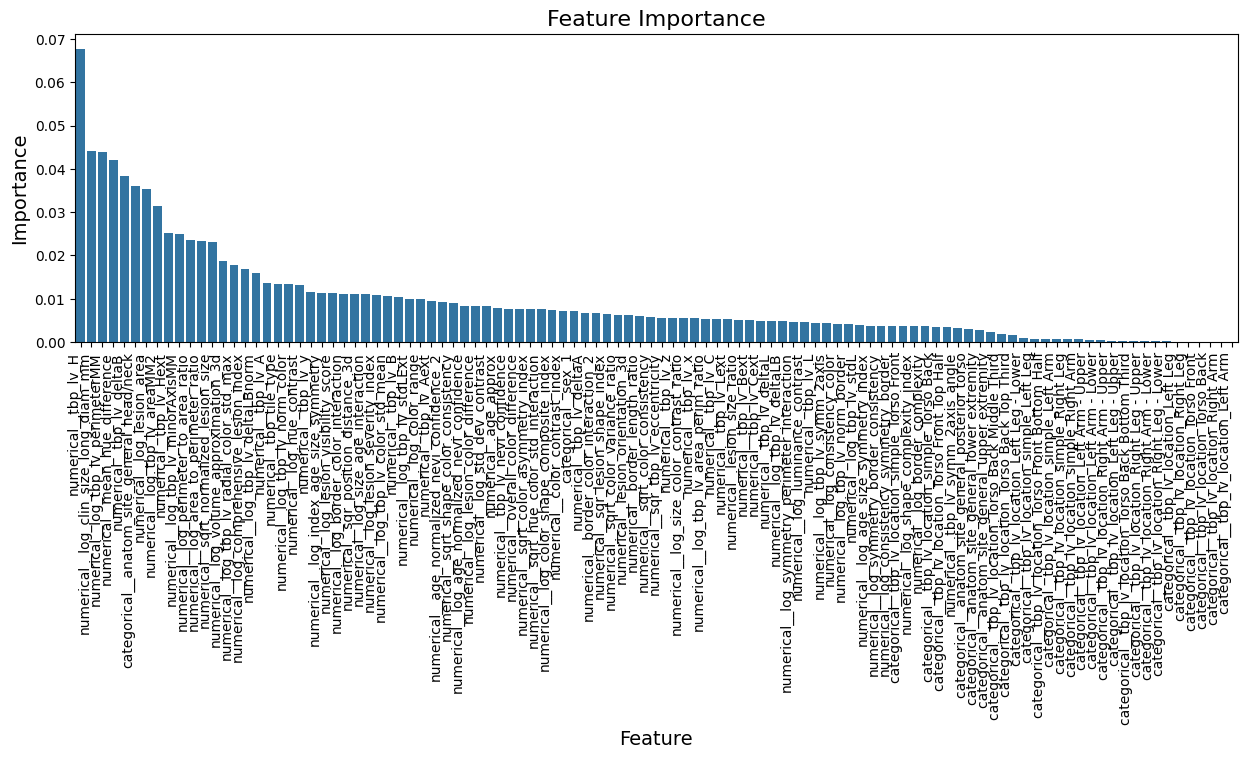

In [94]:
#rf_model = model_rf_fe139_rsmpl.named_steps['RF']  # Replace 'rf' with the actual name used in your pipeline
importances = model_rf_fe139_rsmpl.named_steps['RF'].feature_importances_
feature_names = model_rf_fe139_rsmpl.named_steps.preprocessing.get_feature_names_out()

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances,
}).sort_values(by='importance', ascending=False)

# Plot feature importance
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot()
sns.barplot(x='feature', y='importance', data=feature_importance_df, ax=ax)
plt.xticks(rotation=90, ha='right')
plt.title('Feature Importance', fontsize=16)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Importance', fontsize=14)
#plt.tight_layout()
plt.show()

### Model Saving

In [16]:
if ENABLE['rf']['save-model'] == 1:
    dump(model_rf_fe139_rsmpl, 'model_rf_fe139_rsmpl.pkl')

# XGBoost

### Cross-validation

In [11]:
if ENABLE['xgb']['cross-val'] == 1:

    # Setup cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Define the objective function
    def objective(trial):

        # Suggest values for the hyperparameters
        n_estimators = trial.suggest_int('n_estimators', 200, 400)
        #learning_rate = trial.suggest_float('learning_rate', 0.080, 0.090)
        learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 1.0)
        reg_lambda = trial.suggest_float('reg_lambda', 5.0, 10.0)
        alpha = trial.suggest_float('alpha', 0.5, 0.8)
        max_depth = trial.suggest_int('max_depth', 10, 40) #31)
        subsample = trial.suggest_float('subsample', 0.45, 0.70)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.80, 1.0)
        colsample_bylevel = trial.suggest_float('colsample_bylevel', 0.4, 0.7)
        scale_pos_weight = trial.suggest_float('scale_pos_weight', 1, 10)
        eval_metric = 'logloss'
        enable_categorical = True
    
        pauc_scores = []
    
        for train_idx, val_idx in skf.split(X, y):
            
            # Create the folds
            X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
            y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
                    
            # Pipeline                           
            pipe_xgb = ImbPipeline([
                ('preprocessing', preprocessing),
                ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
                ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),
                ('XGB', XGBClassifier(random_state=42,
                                      enable_categorical=enable_categorical,
                                      eval_metric=eval_metric,
                                      n_estimators=n_estimators,
                                      learning_rate=learning_rate,
                                      reg_lambda=reg_lambda,
                                      alpha=alpha,
                                      max_depth=max_depth,
                                      subsample=subsample,
                                      colsample_bytree=colsample_bytree,
                                      colsample_bylevel=colsample_bylevel,                             
                                      scale_pos_weight=scale_pos_weight,
                                    )
                )
            ])
    
            # Train the model
            pipe_xgb.fit(X_train_fold, y_train_fold)
        
            # Predict on the validation set
            preds = pipe_xgb.predict_proba(X_val_fold)[:,1]
        
            # Calculate partical AUC and store it
            pauc = partial_auc_score(y_val_fold, preds)
            pauc_scores.append(pauc)
        
        # Return the average
        return np.mean(pauc_scores)
    
    # Create a study object with 'maximize' direction
    study = optuna.create_study(direction='maximize')
    
    # Start the optimization
    study.optimize(objective, n_trials=500, n_jobs=-1)
    
    # Get the best trial
    best_trial = study.best_trial
    
    print(f'Best trial number: {best_trial.number}')
    print(f'Best value (partial auc - 0.8): {best_trial.value}')
    print(f'Best hyperparameters: {best_trial.params}')
    
#Best trial number: 80
#Best value (partial auc - 0.8): 0.1917259326323112
#Best hyperparameters: {'n_estimators': 208, 'learning_rate': 0.08256404336718554, 'reg_lambda': 6.1374965163887305, 'alpha': 0.6026870768041418, 'max_depth': 21, 'subsample': 0.47434308951793386, 'colsample_bytree': 0.9081510010036246, 'colsample_bylevel': 0.5171030271682259, 'scale_pos_weight': 9.454864886835315}

    
# only 100: Best trial number: 69
#Best value (partial auc - 0.8): 0.1619833989266088
#Best hyperparameters: {'n_estimators': 325, 'learning_rate': 0.0239358725888817, 'reg_lambda': 6.057328942941725, 'alpha': 0.6627506276715351, 'max_depth': 17, 'subsample': 0.6564028670001514, 'colsample_bytree': 0.9527080903454329, 'colsample_bylevel': 0.5067023470220908, 'scale_pos_weight': 2.0900595608989336}

# 500 trials: all features
#Best trial number: 302
#Best value (partial auc - 0.8): 0.16241845251023754
#Best hyperparameters: {'n_estimators': 355, 'learning_rate': 0.02350129709663857, 'reg_lambda': 7.446186723872003, 'alpha': 0.7771046350027803, 'max_depth': 29, 'subsample': 0.6387931077704182, 'colsample_bytree': 0.9345797222249431, 'colsample_bylevel': 0.6348216595111061, 'scale_pos_weight': 2.1117746994222775}

[I 2024-08-28 23:59:43,394] A new study created in memory with name: no-name-b412524a-1469-4231-b91e-e9d69ed91a80
[I 2024-08-29 00:05:56,561] Trial 4 finished with value: 0.15198076109206954 and parameters: {'n_estimators': 204, 'learning_rate': 0.6024065627884674, 'reg_lambda': 9.557929634475924, 'alpha': 0.5570538767749612, 'max_depth': 10, 'subsample': 0.6744457940914905, 'colsample_bytree': 0.9305877516628639, 'colsample_bylevel': 0.6770743698262478, 'scale_pos_weight': 5.598309682980327}. Best is trial 4 with value: 0.15198076109206954.
[I 2024-08-29 00:09:31,212] Trial 1 finished with value: 0.15442817808577797 and parameters: {'n_estimators': 324, 'learning_rate': 0.5351414885457085, 'reg_lambda': 8.7633906680822, 'alpha': 0.5575026211107126, 'max_depth': 19, 'subsample': 0.5215834871024119, 'colsample_bytree': 0.8420933806305675, 'colsample_bylevel': 0.44465484363276503, 'scale_pos_weight': 8.33636383897231}. Best is trial 1 with value: 0.15442817808577797.
[I 2024-08-29 00:09:

Best trial number: 302
Best value (partial auc - 0.8): 0.16241845251023754
Best hyperparameters: {'n_estimators': 355, 'learning_rate': 0.02350129709663857, 'reg_lambda': 7.446186723872003, 'alpha': 0.7771046350027803, 'max_depth': 29, 'subsample': 0.6387931077704182, 'colsample_bytree': 0.9345797222249431, 'colsample_bylevel': 0.6348216595111061, 'scale_pos_weight': 2.1117746994222775}


### Cross-validation Partial AUC Score

In [18]:
param_xgb = {
        'random_state':      42,
        'n_estimators':      208,
        'learning_rate':     0.08256404336718554,
        'reg_lambda':        6.1374965163887305,
        'alpha':             0.6026870768041418,
        'max_depth':         21,
        'subsample':         0.47434308951793386,
        'colsample_bytree':  0.9081510010036246,
        'colsample_bylevel': 0.5171030271682259,
        'scale_pos_weight':  9.454864886835315
    }

model_xgb_cv = ImbPipeline([    
        ('preprocessing', preprocessing),
        ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
        ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),
        ('RF',  XGBClassifier(**param_xgb))
    ])

if ENABLE['xgb']['compute-pauc'] == 1:
    pauc_xgb_cv = cross_val_partial_auc_score(X, y, model_xgb_cv, n_splits=5)    
    print(f"CV Partial AUC Score: {pauc_xgb_cv}")

### Final Training

In [19]:
if ENABLE['xgb']['final-train'] == 1:
                           
    model_xgb_fe139_rsmpl = ImbPipeline([
        ('preprocessing', preprocessing),
        ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
        ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),
        ('XGB', XGBClassifier(**param_xgb))
    ])
    
    model_xgb_fe139_rsmpl.fit(X, y)

### Model Saving

In [20]:
if ENABLE['xgb']['save-model'] == 1:
    dump(model_xgb_fe139_rsmpl, 'model_xgb_fe139_rsmpl.pkl')

# LightGBM

### Cross-validation

In [19]:
if ENABLE['lgb']['cross-val'] == 1:
    
    # Setup cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Define the objective function
    def objective(trial):
        
        # Suggest values for the hyperparameters
        random_state = 42
        objective = 'binary'
        boosting_type = 'gbdt'
        verbosity = -1
        n_estimators = trial.suggest_int('n_estimators', 200, 500)    
        lambda_l1 = trial.suggest_float('lambda_l1', 0.05, 0.10)
        lambda_l2 = trial.suggest_float('lambda_l2', 0.001, 0.010)
        learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 1.0)
        max_depth = trial.suggest_int('max_depth', 20, 50)    
        num_leaves = trial.suggest_int('num_leaves', 20, 20)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1.0)
        colsample_bynode = trial.suggest_float('colsample_bynode', 0.1, 1.0)
        bagging_fraction = trial.suggest_float('bagging_fraction', 0.1, 1.0) 
        bagging_freq = trial.suggest_int('bagging_freq', 0, 15)
        min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 10)
        scale_pos_weight = trial.suggest_float('scale_pos_weight', 1.0, 10.0)
    
        pauc_scores = []
    
        for train_idx, val_idx in skf.split(X, y):

            # Create the folds
            X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
            y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
                        
            # Pipeline
            pipe_lgb = ImbPipeline([
                ('preprocessing', preprocessing),
                ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
                ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),
                ('LGB', LGBMClassifier(random_state=random_state,
                                       verbosity=verbosity,
                                       objective=objective,
                                       boosting_type=boosting_type,                                   
                                       n_estimators=n_estimators,
                                       lambda_l1=lambda_l1,
                                       lambda_l2=lambda_l2,
                                       learning_rate=learning_rate,
                                       max_depth=max_depth,
                                       num_leaves=num_leaves,
                                       colsample_bytree=colsample_bytree,
                                       colsample_bynode=colsample_bynode,
                                       bagging_fraction=bagging_fraction,
                                       bagging_freq=bagging_freq,
                                       min_data_in_leaf=min_data_in_leaf,
                                       scale_pos_weight=scale_pos_weight
                                      )         
                )
            ])
    
            # Train the model
            pipe_lgb.fit(X_train_fold, y_train_fold)
        
            # Predict on the validation set
            preds = pipe_lgb.predict_proba(X_val_fold)[:,1]
        
            # Calculate partical AUC and store it
            pauc = partial_auc_score(y_val_fold, preds)
            pauc_scores.append(pauc)
        
        # Return the average
        return np.mean(pauc_scores)
    
    # Create a study object with 'maximize' direction
    study = optuna.create_study(direction='maximize')
    
    # Start the optimization
    study.optimize(objective, n_trials=500, n_jobs=-1)
    
    # Get the best trial
    best_trial = study.best_trial
    
    print(f'Best trial number: {best_trial.number}')
    print(f'Best value (partial auc - 0.8): {best_trial.value}')
    print(f'Best hyperparameters: {best_trial.params}')
        
#Best value (partial auc - 0.8): 0.19165167013143908
#Best hyperparameters: {'n_estimators': 390, 'lambda_l1': 0.05127158993500609, 'lambda_l2': 0.002856268451232568, 'learning_rate': 0.016316428473444125, 'max_depth': 32, 'num_leaves': 20, 'colsample_bytree': 0.501841654985379, 'colsample_bynode': 0.3253277554214308, 'bagging_fraction': 0.22054551329713584, 'bagging_freq': 5, 'min_data_in_leaf': 9, 'scale_pos_weight': 1.0154421072327424}

#All Features Best trial number: 284
#Best value (partial auc - 0.8): 0.16269973090142653
#Best hyperparameters: {'n_estimators': 412, 'lambda_l1': 0.05008278004940379, 'lambda_l2': 0.006659423244243366, 'learning_rate': 0.01688752290762689, 'max_depth': 37, 'num_leaves': 20, 'colsample_bytree': 0.8517997629490393, 'colsample_bynode': 0.48234872015048935, 'bagging_fraction': 0.19871997756356247, 'bagging_freq': 0, 'min_data_in_leaf': 2, 'scale_pos_weight': 8.924820755418924}

[I 2024-08-29 12:25:48,443] A new study created in memory with name: no-name-652d4160-8d6c-4469-823b-3d33f72ca260
[I 2024-08-29 12:27:00,672] Trial 12 finished with value: 0.06409449490457649 and parameters: {'n_estimators': 497, 'lambda_l1': 0.08434805427427947, 'lambda_l2': 0.009845311267408854, 'learning_rate': 0.8300352809707737, 'max_depth': 38, 'num_leaves': 20, 'colsample_bytree': 0.802355479522042, 'colsample_bynode': 0.6132780179226867, 'bagging_fraction': 0.24406003983886154, 'bagging_freq': 4, 'min_data_in_leaf': 6, 'scale_pos_weight': 4.425301633039536}. Best is trial 12 with value: 0.06409449490457649.
[I 2024-08-29 12:27:16,365] Trial 8 finished with value: 0.04392192429114083 and parameters: {'n_estimators': 329, 'lambda_l1': 0.06744754080595661, 'lambda_l2': 0.006947415161756249, 'learning_rate': 0.6047453808509101, 'max_depth': 31, 'num_leaves': 20, 'colsample_bytree': 0.3015845328647966, 'colsample_bynode': 0.1419010001494085, 'bagging_fraction': 0.4444628926792924, '

Best trial number: 332
Best value (partial auc - 0.8): 0.16087182325964494
Best hyperparameters: {'n_estimators': 486, 'lambda_l1': 0.07449758499894217, 'lambda_l2': 0.0021676093526742865, 'learning_rate': 0.019802479315426166, 'max_depth': 26, 'num_leaves': 20, 'colsample_bytree': 0.39719212588248054, 'colsample_bynode': 0.5863776741117672, 'bagging_fraction': 0.9633056847206067, 'bagging_freq': 9, 'min_data_in_leaf': 10, 'scale_pos_weight': 2.1646326618745437}


### Cross-validation Partial AUC Score

In [15]:
param_lgb = {
        'random_state':     42,
        'objective':        'binary',
        'boosting_type':    'gbdt',
        'verbosity':        -1,
        'n_estimators':     412, #390,
        'lambda_l1':        0.05008278004940379, #0.05127158993500609,
        'lambda_l2':        0.006659423244243366, #0.002856268451232568,
        'learning_rate':    0.01688752290762689, #0.016316428473444125,
        'max_depth':        37, #32,
        'num_leaves':       20,
        'colsample_bytree': 0.8517997629490393, #0.501841654985379, 
        'colsample_bynode': 0.48234872015048935, #0.3253277554214308,
        'bagging_fraction': 0.19871997756356247, #0.22054551329713584,
        'bagging_freq':     0, #5,
        'min_data_in_leaf': 2, #9,
        'scale_pos_weight': 8.924820755418924, #1.0154421072327424,
    }


model_lgb_cv = ImbPipeline([    
        ('preprocessing', preprocessing),
        ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
        ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),
        ('LGB',  LGBMClassifier(**param_lgb))
    ])

if ENABLE['lgb']['compute-pauc'] == 1:
    pauc_lgb_cv = cross_val_partial_auc_score(X, y, model_lgb_cv, n_splits=5)
    print(f"CV Partial AUC Score: {pauc_lgb_cv}")

Processing fold 1 of 5... pAUC: 0.15037914423058735
Processing fold 2 of 5... pAUC: 0.1642692823136436
Processing fold 3 of 5... pAUC: 0.16009653216932296
Processing fold 4 of 5... pAUC: 0.16188443455795506
Processing fold 5 of 5... pAUC: 0.15971681960641465
CV Partial AUC Score: 0.15926924257558475


### Final Training

In [23]:
if ENABLE['lgb']['final-train'] == 1:
    
    # Pipeline                          
    model_lgb_fe139_rsmpl = ImbPipeline([
        ('preprocessing', preprocessing),  
        ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
        ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),    
        ('LGB', LGBMClassifier(**param_lgb))
    ])
    
    model_lgb_fe139_rsmpl.fit(X, y)

### Model Saving

In [24]:
if ENABLE['lgb']['save-model'] == 1:
    dump(model_lgb_fe139_rsmpl, 'model_lgb_fe139_rsmpl.pkl')

# CatBoost

### Cross-validation

In [25]:
if ENABLE['cb']['cross-val'] == 1:
    
    # Setup cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Define the objective function
    def objective(trial):
            
        # Suggest values for the hyperparameters
        random_state = 42
        loss_function = 'Logloss'
        verbose = False
        n_estimators = trial.suggest_int('n_estimators', 200, 400)    
        max_depth = trial.suggest_int('max_depth', 1, 16)
        learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 1.0)    
        scale_pos_weight = trial.suggest_float('scale_pos_weight', 1.0, 10.0) #4.0)
        l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1.0, 10.0) #8.0)
        subsample = trial.suggest_float('subsample', 0.1, 1.0) #0.8)
        min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 35) # 15, 35)
        
        pauc_scores = []
        
        for train_idx, val_idx in skf.split(X, y):

            # Create the folds
            X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
            y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
                    
            # Pipeline
            pipe_cb = ImbPipeline([
                ('preprocessing', preprocessing),  
                ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
                ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),    
                ('CAT', CatBoostClassifier(random_state=random_state,                               
                                           loss_function=loss_function,
                                           verbose=verbose,
                                           n_estimators=n_estimators,                               
                                           max_depth=max_depth,
                                           learning_rate=learning_rate,
                                           scale_pos_weight=scale_pos_weight,
                                           l2_leaf_reg=l2_leaf_reg,
                                           subsample=subsample,
                                           min_data_in_leaf=min_data_in_leaf,
                                        )         
                )
            ])
    
            # Train the model
            pipe_cb.fit(X_train_fold, y_train_fold)
        
            # Predict on the validation set
            preds = pipe_cb.predict_proba(X_val_fold)[:,1]
        
            # Calculate partical AUC and store it
            pauc = partial_auc_score(y_val_fold, preds)
            pauc_scores.append(pauc)
        
        # Return the average
        return np.mean(pauc_scores)
    
    # Create a study object with 'maximize' direction
    study = optuna.create_study(direction='maximize')
    
    # Start the optimization
    study.optimize(objective, n_trials=100, n_jobs=-1)
    
    # Get the best trial
    best_trial = study.best_trial
    
    print(f'Best trial number: {best_trial.number}')
    print(f'Best value (partial auc - 0.8): {best_trial.value}')
    print(f'Best hyperparameters: {best_trial.params}')
    
# TRIAL
#Trial 30 finished with value: 0.19182318666176065
#and parameters: {'n_estimators': 352, 'max_depth': 12, 'learning_rate': 0.010916211896675203, 'scale_pos_weight': 1.1308423310589069, 'l2_leaf_reg': 9.938943422516182, 'subsample': 0.48191020552292485, 'min_data_in_leaf': 35}. Best is trial 30 with value: 0.19182318666176065.

### Cross-validation Partial AUC Score

In [26]:
param_cb = {
        'random_state':     42,
        'loss_function':    'Logloss',
        'verbose':          False,
        'n_estimators':     352,
        'max_depth':        12,
        'learning_rate':    0.010916211896675203,
        'scale_pos_weight': 1.1308423310589069,
        'l2_leaf_reg':      9.938943422516182,
        'subsample':        0.48191020552292485, 
        'min_data_in_leaf': 35
    }

model_cb_cv = ImbPipeline([    
        ('preprocessing', preprocessing),
        ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
        ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),
        ('CB',  CatBoostClassifier(**param_cb))
    ])

if ENABLE['cb']['compute-pauc'] == 1:
    pauc_cb_cv = cross_val_partial_auc_score(X, y, model_cb_cv, n_splits=5)
    print(f"CV Partial AUC Score: {pauc_cb_cv}")

### Final Training

In [27]:
if ENABLE['cb']['final-train'] == 1:
        
    model_cb_fe139_rsmpl = ImbPipeline([
        ('preprocessing', preprocessing),
        ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
        ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),
        ('CAT', CatBoostClassifier(**param_cb)         
        )
    ])
    
    model_cb_fe139_rsmpl.fit(X, y)

### Model Saving

In [28]:
if ENABLE['cb']['save-model'] == 1:
    dump(model_cb_fe139_rsmpl, 'model_cb_fe139_rsmpl.pkl')

# AdaBoost

### Cross-validation

In [29]:
if ENABLE['ada']['cross-val'] == 1:
    
    # Setup cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Define the objective function
    def objective(trial):
            
        # Suggest values for the hyperparameters
        random_state = 42
        n_estimators = trial.suggest_int('n_estimators', 50, 400)
        learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 1.0) 
        
        pauc_scores = []

        for train_idx, val_idx in skf.split(X, y):
            # Create the folds
            X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
            y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

            # Pipeline                                       
            pipe_ada = ImbPipeline([
                ('preprocessing', preprocessing),
                ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
                ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),
                ('ADA', AdaBoostClassifier(random_state=42,                             
                                           n_estimators=n_estimators,
                                           learning_rate=learning_rate                             
                                          )
                )
            ])
    
            # Train the model
            pipe_ada.fit(X_train_fold, y_train_fold)
        
            # Predict on the validation set
            preds = pipe_ada.predict_proba(X_val_fold)[:,1]
        
            # Calculate partical AUC and store it
            pauc = partial_auc_score(y_val_fold, preds)
            pauc_scores.append(pauc)
        
        # Return the average
        return np.mean(pauc_scores)
    
    # Create a study object with 'maximize' direction
    study = optuna.create_study(direction='maximize')
    
    # Start the optimization
    study.optimize(objective, n_trials=100, n_jobs=-1)
    
    # Get the best trial
    best_trial = study.best_trial
    
    print(f'Best trial number: {best_trial.number}')
    print(f'Best value (partial auc - 0.8): {best_trial.value}')
    print(f'Best hyperparameters: {best_trial.params}')

#Best trial number: 53
#Best value (partial auc - 0.8): 0.19173484739529267
#Best hyperparameters: {'n_estimators': 352, 'learning_rate': 0.022798770211700257}

#Trial 38 finished with value: 0.19175458060851266 and parameters: {'n_estimators': 276, 'learning_rate': 0.02915033101191371}. Best is trial 38 with value: 0.19175458060851266.

### Cross-validaton Partial AUC Score

In [30]:
param_ada = {
        'random_state':  42,
        'n_estimators':  276, #352,  
        'learning_rate': 0.02915033101191371 #0.022798770211700257
    }

model_ada_cv = ImbPipeline([    
        ('preprocessing', preprocessing),
        ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
        ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),
        ('ADA', AdaBoostClassifier(**param_ada))
    ])

if ENABLE['ada']['compute-pauc'] == 1:
    pauc_ada_cv = cross_val_partial_auc_score(X, y, model_ada_cv, n_splits=5)    
    print(f"CV Partial AUC Score: {pauc_ada_cv}")

### Final Training

In [31]:
if ENABLE['ada']['final-train'] == 1:
    
    # Pipeline                              
    model_ada_fe139_rsmpl = ImbPipeline([
        ('preprocessing', preprocessing),  
        ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
        ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),    
        ('ADA', AdaBoostClassifier(**param_ada)
        )
    ])
    
    model_ada_fe139_rsmpl.fit(X, y)

### Model Saving

In [32]:
if ENABLE['ada']['save-model'] == 1:
    dump(model_ada_fe139_rsmpl, 'model_ada_fe139_rsmpl.pkl')

# SVC

In [33]:
if ENABLE['svc']['cross-val'] == 1:
    
    # Setup cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Define the objective function
    def objective(trial):
            
        # Suggest values for the hyperparameters
        random_state = 42
        probability = True
        kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
        C = trial.suggest_loguniform('C', 0.0001, 10.0)
        gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
        #class_weight = trial.suggest_categorical('class_weight', [None, 'balanced']) 
        class_weight = 'balanced'
        pauc_scores = []
        
        for train_idx, val_idx in skf.split(X, y):
            # Create the folds
            X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
            y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
                    
            # Pipeline
            pipe_svc = ImbPipeline([
                ('preprocessing', preprocessing),  
                ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
                ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),    
                ('SVC', SVC(random_state=random_state,
                            probability=probability,
                            kernel=kernel,
                            C=C,
                            gamma=gamma,
                            class_weight=class_weight
                           )
                )
            ])
    
            # Train the model
            pipe_svc.fit(X_train_fold, y_train_fold)
        
            # Predict on the validation set
            preds = pipe_svc.predict_proba(X_val_fold)[:,1]
        
            # Calculate partical AUC and store it
            pauc = partial_auc_score(y_val_fold, preds)
            pauc_scores.append(pauc)
        
        # Return the average
        return np.mean(pauc_scores)
    
    # Create a study object with 'maximize' direction
    study = optuna.create_study(direction='maximize')
    
    # Start the optimization
    study.optimize(objective, n_trials=100, n_jobs=-1)
    
    # Get the best trial
    best_trial = study.best_trial
    
    print(f'Best trial number: {best_trial.number}')
    print(f'Best value (partial auc - 0.8): {best_trial.value}')
    print(f'Best hyperparameters: {best_trial.params}')

#Best value (partial auc - 0.8): 0.19117447674037716
#Best hyperparameters: {'kernel': 'poly', 'C': 0.0061928828007692584, 'gamma': 'scale', 'class_weight': 'balanced'}.

#Trial 27 finished with value: 0.19127118606665136 and parameters: {'kernel': 'linear', 'C': 0.00012545092811368545, 'gamma': 'auto'}. Best is trial 27 with value: 0.19127118606665136.

### Cross-validation Partial AUC Score

In [34]:
param_svc = {
        'random_state': 42,
        'probability': True,
        'kernel': 'linear',
        'C': 0.00012545092811368545,
        'gamma': 'auto',
        'class_weight': 'balanced'
}

model_svc_cv = ImbPipeline([    
        ('preprocessing', preprocessing),
        ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
        ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),
        ('SVC', SVC(**param_svc))
])

if ENABLE['svc']['compute-pauc'] == 1:
    pauc_svc_cv = cross_val_partial_auc_score(X, y, model_svc_cv, n_splits=5)
    print(f"CV Partial AUC Score: {pauc_svc_cv}")

### Final Training

In [35]:
if ENABLE['svc']['final-train'] == 1:
    
    # Pipeline
    model_svc_fe139_rsmpl = ImbPipeline([
        ('preprocessing', preprocessing),  
        ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
        ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),    
        ('SVC', SVC(**param_svc)
        )
    ])
    
    model_svc_fe139_rsmpl.fit(X, y)

### Model Saving

In [36]:
if ENABLE['svc']['save-model'] == 1:
    dump(model_svc_fe139_rsmpl, 'model_svc_fe139_rsmpl.pkl')

# Ensemble: Soft Voting

### Cross-validation Partial AUC Score

In [99]:
# Different paths for numerical and categorical features
pipe_num = Pipeline([
    ('scaler', RobustScaler()),
    ('kbest', SelectKBest(score_func=f_classif, k=KBEST_NUM)),   
])

pipe_cat = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)),
    ('kbest', SelectKBest(score_func=chi2, k=KBEST_CAT)),    
])

col_transform = ColumnTransformer(transformers=[
    ('numerical', pipe_num, numerical_features),
    ('categorical',pipe_cat, categorical_features)
])

preprocessing = ImbPipeline([
    ('col_transform', col_transform),
    ('undersampler', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
    ('oversampler', SMOTE(sampling_strategy={1: 4000}, random_state=42))
])

# Random Forest

# From Optuna:
param_rf = {
        'random_state': 42,
        'n_estimators': 138,
        'max_depth': 12,
        'min_samples_split': 5,
        'min_samples_leaf': 8,
        'bootstrap': True,
        'class_weight': 'balanced_subsample',
        'n_jobs': -1
}

model_rf = BalancedRandomForestClassifier(**param_rf)

# XGBoost

# From Optuna:
param_xgb = {
        'random_state':      42,
        'n_estimators':      208,
        'learning_rate':     0.08256404336718554,
        'reg_lambda':        6.1374965163887305,
        'alpha':             0.6026870768041418,
        'max_depth':         21,
        'subsample':         0.47434308951793386,
        'colsample_bytree':  0.9081510010036246,
        'colsample_bylevel': 0.5171030271682259,
        'scale_pos_weight':  9.454864886835315
}

model_xgb = XGBClassifier(**param_xgb)

# LightGBM

# From Optuna:
param_lgb = {
        'random_state':     42,
        'objective':        'binary',
        'boosting_type':    'gbdt',
        'verbosity':        -1,
        'n_estimators':     390,
        'lambda_l1':        0.05127158993500609,
        'lambda_l2':        0.002856268451232568,
        'learning_rate':    0.016316428473444125,
        'max_depth':        32,
        'num_leaves':       20,
        'colsample_bytree': 0.501841654985379, 
        'colsample_bynode': 0.3253277554214308,
        'bagging_fraction': 0.22054551329713584,
        'bagging_freq':     5,
        'min_data_in_leaf': 9,
        'scale_pos_weight': 1.0154421072327424,
    }

model_lgb = LGBMClassifier(**param_lgb)

# CatBoost

# From Optuna:
param_cb = {
        'random_state':     42,
        'loss_function':    'Logloss',
        'verbose':          False,
        'n_estimators':     352,
        'max_depth':        12,
        'learning_rate':    0.010916211896675203,
        'scale_pos_weight': 1.1308423310589069,
        'l2_leaf_reg':      9.938943422516182,
        'subsample':        0.48191020552292485, 
        'min_data_in_leaf': 35
    }

model_cb = CatBoostClassifier(**param_cb)


# AdaBoost

# From Optuna:
param_ada = {
        'random_state':  42,
        'n_estimators':  276, #352,  
        'learning_rate': 0.02915033101191371 #0.022798770211700257
    }

model_ada = AdaBoostClassifier(**param_ada)


# SVC

# From Optuna:
param_svc = {
        'random_state': 42,
        'probability': True,
        'kernel': 'linear',
        'C': 0.00012545092811368545,
        'gamma': 'auto',
        'class_weight': 'balanced'
}

model_svc = SVC(**param_svc)


# Ensemble: Soft Voting

# Build the soft-voting ensemble archicecture
model_soft_voting = VotingClassifier(estimators=[
        ('RF',  model_rf),
        ('XGB', model_xgb),
        ('LGB', model_lgb),
        ('CB',  model_cb),
        ('ADA', model_ada),
        ('SVC', model_svc)
], voting='soft')

X_p, y_p = preprocessing.fit_resample(X, y)

# Convert to DataFrame and Series, as X_p and y_p are numpy
X_p = pd.DataFrame(X_p)
y_p = pd.Series(y_p)

Contains NaN: False


In [ ]:
# Average pAUC across the folds
pauc_sft = cross_val_partial_auc_score(X_p, y_p, model_soft_voting, n_splits=5)
print(f"CV Partial AUC Score: {pauc_sft}")

In [109]:
# Build the soft-voting ensemble archicecture
model_soft_cv = VotingClassifier(estimators=[
        ('RF',  model_rf_cv),
        ('XGB', model_xgb_cv),
        ('LGB', model_lgb_cv),
        ('CB',  model_cb_cv),
        ('ADA', model_ada_cv),
        ('SVC', model_svc_cv)
], voting='soft')

if ENABLE['soft-v']['compute-pauc'] == 1:
    pauc_sft_cv = cross_val_partial_auc_score(X, y, model_soft_cv, n_splits=5)
    print(f"CV Partial AUC Score: {pauc_sft_cv}")

Processing fold 1 of 5... pAUC: 0.1913498316713085
Processing fold 2 of 5... pAUC: 0.19263918168824876
Processing fold 3 of 5... pAUC: 0.1893449845486345
Processing fold 4 of 5... pAUC: 0.19343472612065452
Processing fold 5 of 5... pAUC: 0.19327905936373685
CV Partial AUC Score: 0.19200955667851663


In [37]:
# Build the soft-voting ensemble archicecture
model_soft_cv = VotingClassifier(estimators=[
        ('RF',  model_rf_cv),
        ('XGB', model_xgb_cv),
        ('LGB', model_lgb_cv),
        ('CB',  model_cb_cv),
        ('ADA', model_ada_cv),
        ('SVC', model_svc_cv)
], voting='soft')

if ENABLE['soft-v']['compute-pauc'] == 1:
    pauc_sft_cv = cross_val_partial_auc_score(X, y, model_soft_cv, n_splits=5)
    print(f"CV Partial AUC Score: {pauc_sft_cv}")

Processing fold 1 of 5... pAUC: 0.1913498316713085
Processing fold 2 of 5... pAUC: 0.19263918168824876
Processing fold 3 of 5... pAUC: 0.1893449845486345
Processing fold 4 of 5... pAUC: 0.19343472612065452
Processing fold 5 of 5... pAUC: 0.19327905936373685
CV Partial AUC Score: 0.19200955667851663


In [46]:
# Build the soft-voting ensemble archicecture
model_soft_cv = VotingClassifier(estimators=[
        ('RF',  model_rf_cv),
        ('XGB', model_xgb_cv),
        ('LGB', model_lgb_cv),
        ('CB',  model_cb_cv),
        ('ADA', model_ada_cv),
        #('SVC', model_svc_cv)
], voting='soft')

if ENABLE['soft-v']['compute-pauc'] == 1:
    pauc_sft_cv = cross_val_partial_auc_score(X, y, model_soft_cv, n_splits=5)
    print(f"CV Partial AUC Score: {pauc_sft_cv}")

Processing fold 1 of 5... pAUC: 0.19134550445558976
Processing fold 2 of 5... pAUC: 0.19269046720787847
Processing fold 3 of 5... pAUC: 0.18868724775938367
Processing fold 4 of 5... pAUC: 0.19347287178058742
Processing fold 5 of 5... pAUC: 0.1932013071462566
CV Partial AUC Score: 0.19187947966993918


In [47]:
# Build the soft-voting ensemble archicecture
model_soft_cv = VotingClassifier(estimators=[
        ('RF',  model_rf_cv),
        ('XGB', model_xgb_cv),
        ('LGB', model_lgb_cv),
        ('CB',  model_cb_cv),
        #('ADA', model_ada_cv),
        ('SVC', model_svc_cv)
], voting='soft')

if ENABLE['soft-v']['compute-pauc'] == 1:
    pauc_sft_cv = cross_val_partial_auc_score(X, y, model_soft_cv, n_splits=5)
    print(f"CV Partial AUC Score: {pauc_sft_cv}")

Processing fold 1 of 5... pAUC: 0.19121104023381064
Processing fold 2 of 5... pAUC: 0.19252651381231226
Processing fold 3 of 5... pAUC: 0.18939883434424568
Processing fold 4 of 5... pAUC: 0.19359753504368735
Processing fold 5 of 5... pAUC: 0.19292893090213994
CV Partial AUC Score: 0.19193257086723917


In [48]:
# Build the soft-voting ensemble archicecture
model_soft_cv = VotingClassifier(estimators=[
        ('RF',  model_rf_cv),
        ('XGB', model_xgb_cv),
        ('LGB', model_lgb_cv),
        ('CB',  model_cb_cv),
        #('ADA', model_ada_cv),
        #('SVC', model_svc_cv)
], voting='soft')

if ENABLE['soft-v']['compute-pauc'] == 1:
    pauc_sft_cv = cross_val_partial_auc_score(X, y, model_soft_cv, n_splits=5)
    print(f"CV Partial AUC Score: {pauc_sft_cv}")

Processing fold 1 of 5... pAUC: 0.1911887630862215
Processing fold 2 of 5... pAUC: 0.19250407639747427
Processing fold 3 of 5... pAUC: 0.18892748836539902
Processing fold 4 of 5... pAUC: 0.19367658583682487
Processing fold 5 of 5... pAUC: 0.19269064226902718
CV Partial AUC Score: 0.1917975111909894


In [49]:
# Build the soft-voting ensemble archicecture
model_soft_cv = VotingClassifier(estimators=[
        #('RF',  model_rf_cv),
        ('XGB', model_xgb_cv),
        ('LGB', model_lgb_cv),
        ('CB',  model_cb_cv),
        ('ADA', model_ada_cv),
        ('SVC', model_svc_cv)
], voting='soft')

if ENABLE['soft-v']['compute-pauc'] == 1:
    pauc_sft_cv = cross_val_partial_auc_score(X, y, model_soft_cv, n_splits=5)
    print(f"CV Partial AUC Score: {pauc_sft_cv}")

Processing fold 1 of 5... pAUC: 0.1911445293255409
Processing fold 2 of 5... pAUC: 0.19277284457378369
Processing fold 3 of 5... pAUC: 0.18977369943928896
Processing fold 4 of 5... pAUC: 0.19338775014625204
Processing fold 5 of 5... pAUC: 0.1934033979829224
CV Partial AUC Score: 0.1920964442935576


### Final Training

In [38]:
if ENABLE['soft-v']['final-train'] == 1:
    model_soft_cv_fe130_rsmpl = VotingClassifier(estimators=[
        ('RF',  model_rf_cv),
        ('XGB', model_xgb_cv),
        ('LGB', model_lgb_cv),
        ('CB',  model_cb_cv),
        ('ADA', model_ada_cv),
        ('SVC', model_svc_cv)
        ], voting='soft')

    # In case that the individual models have been trained before
    
    #model_rf_fe139_rsmpl = load('model_rf_fe139_rsmpl.pkl')
    #model_xgb_fe139_rsmpl = load('model_xgb_fe139_rsmpl.pkl')
    #model_lgb_fe139_rsmpl = load('model_lgb_fe139_rsmpl.pkl')
    #model_cb_fe139_rsmpl = load('model_cb_fe139_rsmpl.pkl')
    #model_cb_fe139_rsmpl = load('model_ada_fe139_rsmpl.pkl')
    #model_svc_fe139_rsmpl = load('model_svc_fe139_rsmpl.pkl')
    #model_soft_cv_fe130_rsmpl = VotingClassifier(estimators=[
    #    ('RF',  model_rf_fe139_rsmpl),
    #    ('XGB', model_xgb_fe139_rsmpl),
    #    ('LGB', model_lgb_fe139_rsmpl),
    #    ('CB',  model_cb_fe139_rsmpl),
    #    ('ADA', model_cb_fe139_rsmpl),
    #    ('SVC', model_svc_fe139_rsmpl)
    #], voting='soft')

    model_soft_cv_fe130_rsmpl.fit(X, y)

### Model Saving

In [44]:
if ENABLE['soft-v']['save-model'] == 1:
    dump(model_soft_cv_fe130_rsmpl, 'model_soft_cv_fe130_rsmpl.pkl')

# Ensemble: Logistic Regression


In [ ]:
if ENABLE['lr-v']['cross-val'] == 1:
    
estimators=[
        ('RF',  model_rf_cv),
        ('XGB', model_xgb_cv),
        ('LGB', model_lgb_cv),
        ('CB',  model_cb_cv),
        ('ADA', model_ada_cv),
        ('SVC', model_svc_cv)

stacking_lr = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

# Construct a pipeline with StackingClassifier
pipe_lr_soft = Pipeline([
    ('stacking_clf', stacking_lr)
])


# Define hyperparameters only for LogisticRegression()
hyperparams = {
    'stacking_clf__final_estimator__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'stacking_clf__final_estimator__penalty': ['l1', 'l2'],
    'stacking_clf__final_estimator__solver': ['liblinear', 'saga']
}

meta = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression())


### Cross-validation Partial AUC Score

### Final Training

In [ ]:
if ENABLE['lr-v']['final-train'] == 1:

    param_lr_v = {
        'C': ???,
        'penaly': ???,
        'solver': ???
    }
    
    estimators=[
        ('RF',  model_rf_cv),
        ('XGB', model_xgb_cv),
        ('LGB', model_lgb_cv),
        ('CB',  model_cb_cv),
        ('ADA', model_ada_cv),
        ('SVC', model_svc_cv)
 
    stacking_lr = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

    # Construct a pipeline with StackingClassifier
    model_lr_cv_fe130_rsmpl = Pipeline([('stacking_clf', stacking_lr)])

    model_lr_cv_fe130_rsmpl.fit(X, y)

# Summary

In [45]:
print("Model Performance Scores:\n")
print(f"{'Model':<15} {'Partial AUC Score':<20}")
print("-" * 35)
if 'pauc_rf_cv' in locals():
    print(f"{'Random Forest':<15} {pauc_rf_cv:<20.4f}")
if 'pauc_xgb_cv' in locals():    
    print(f"{'XGBoost':<15} {pauc_xgb_cv:<20.4f}")
if 'pauc_lgb_cv' in locals():    
    print(f"{'LightGBM':<15} {pauc_lgb_cv:<20.4f}")
if 'pauc_cb_cv' in locals():        
    print(f"{'CatBoost':<15} {pauc_cb_cv:<20.4f}")
if 'pauc_ada_cv' in locals():    
    print(f"{'AdaBoost':<15} {pauc_ada_cv:<20.4f}")
if 'pauc_svc_cv' in locals():        
    print(f"{'SVC':<15} {pauc_svc_cv:<20.4f}")
if 'pauc_sft_cv' in locals():        
    print(f"{'Soft Voting':<15} {pauc_sft_cv:<20.4f}")

Model Performance Scores:

Model           Partial AUC Score   
-----------------------------------
Soft Voting     0.1920              


In [41]:
# Initialize cross-validation

#skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#pauc_scores = []

# Cross-validation loop
#for train_idx, val_idx in skf.split(X, y):
            
    # Create the folds
#    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
#    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    # Create the ensemble model. Assumed these models already pretrained
#    soft_voting_model = VotingClassifier(estimators=[
#        ('RF',  model_rf_fe139_rsmpl),
#        ('XGB', model_xgb_fe139_rsmpl),
#        ('LGB', model_lgb_fe139_rsmpl),
#        ('CB',  model_cb_fe139_rsmpl),
#        ('ADA', model_ada_fe139_rsmpl),
#        ('SVC', model_svc_fe139_rsmpl),
        
    # Make predictions with the validation set
    #preds1 = model_rf_fe139_rsmpl.predict_proba(X_val_fold)[:,1]
    #preds2 = model_xgb_fe139_rsmpl.predict_proba(X_val_fold)[:,1]
    #preds3 = model_lgb_fe139_rsmpl.predict_proba(X_val_fold)[:,1]
    #preds4 = model_cb_fe139_rsmpl.predict_proba(X_val_fold)[:,1]
    #preds5 = model_ada_fe139_rsmpl.predict_proba(X_val_fold)[:,1]
    #preds6 = model_svc_fe139_rsmpl.predict_proba(X_val_fold)[:,1]

    #pauc1 = partial_auc_score(y_val_fold, preds1)
    #pauc2 = partial_auc_score(y_val_fold, preds2)
    #pauc3 = partial_auc_score(y_val_fold, preds3)
    #pauc4 = partial_auc_score(y_val_fold, preds4)
    #pauc5 = partial_auc_score(y_val_fold, preds5)
    #pauc6 = partial_auc_score(y_val_fold, preds6)
    
    # Combine the partial AUC scores using the average
    #pauc_ave = np.mean([preds1, preds2, preds3, preds4, preds5, preds6])

    # Predict on the validation set
#    preds = soft_voting_model.predict_proba(X_val_fold)[:,1]
        
    # Calculate partical AUC and store it
#    pauc = partial_auc_score(y_val_fold, preds)
#    pauc_scores.append(pauc)

# Average the scores across all folds
#average_ensemble_score = np.mean(pauc_scores)
#print(f'Average partical AUC score - Soft Voting: {average_ensemble_score}')

In [42]:
# Feature Importance

In [43]:
#importances = model.feature_importances_
#feature_importance_df = pd.DataFrame({
#    'feature': selected_features,  # This should correspond to your final set of features after KBest
#    'importance': importances
#}).sort_values(by='importance', ascending=False)

# Plot feature importance
#sns.barplot(x='importance', y='feature', data=feature_importance_df)
#plt.title('Feature Importance')
#plt.show()

In [ ]:
from sklearn.ensemble import StackingClassifier, BalancedRandomForestClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

# Define the CNNWrapper class
class CNNWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, cnn_preds):
        self.cnn_preds = cnn_preds
        
    def fit(self, X, y=None):
        return self
    
    def predict_proba(self, X):
        # Since we're using precomputed predictions, just return them
        return self.cnn_preds

# Instantiate your CNN wrapper with the precomputed CNN predictions
cnn_wrapper = CNNWrapper(cnn_preds[['cnn_prob']])

# Define the base estimators
estimators = [
    ('RF', model_rf_cv),
    ('XGB', model_xgb_cv),
    ('LGB', model_lgb_cv),
    ('CB', model_cb_cv),
    ('ADA', model_ada_cv),
    ('SVC', model_svc_cv),
    ('CNN', cnn_wrapper)
]

# Create the stacking classifier with BalancedRandomForestClassifier as the final estimator
stacking_rf = StackingClassifier(
    estimators=estimators,
    final_estimator=BalancedRandomForestClassifier()  # Using BalancedRandomForestClassifier here
)

# Fit the stacking classifier on your training data
stacking_rf.fit(X_train, y_train)
